In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(400)
rn.seed(400)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.random.set_seed(400)
sess = tf.compat.v1.Session(config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split

x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.175)

In [5]:
import cv2
import numpy as np

x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_valid = np.array([cv2.resize(img, (32, 32)) for img in x_valid])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

print(x_train.shape, x_valid.shape, x_test.shape) 

(60000, 32, 32) (10500, 32, 32) (10000, 32, 32)


In [6]:
# import keras
# 0-255の整数値を0〜1の小数に変換する
# MNISTって必ずこの処理入るけれど、意味あるのかな
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_valid /= 255.0
x_test /= 255.0

# one-hot vector形式に変換する
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [7]:
def arg_max(y):
    max_value = 0.
    max_index = 11.
    for i in range(10 - 1):
        if(max_value < y[i]):
            max_value = y[i]
            max_index = float(i)
    return max_index

In [8]:
a = tf.constant([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])
# b = tf.constant([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])
b = tf.constant([[0.], [1.], [2.], [3.], [4.], [5.], [6.], [7.], [8.], [9.]])

c = tf.matmul(a, b)

In [9]:
tf.keras.backend.sum(
    c, axis=None, keepdims=False
)

<tf.Tensor: shape=(), dtype=float32, numpy=855.0>

In [10]:
def custom_loss(y_true, y_pred):
    c_cross_entropy = tf.keras.losses.categorical_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0)
    
    # y_true = tf.cast(y_true, tf.float32)

    # digit = tf.constant([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])
    digit = tf.constant([[0.], [1.], [2.], [3.], [4.], [5.], [6.], [7.], [8.], [9.]])

    true = tf.matmul(y_true, digit)
    pred = tf.matmul(y_pred, digit)
    
    digit_error = tf.subtract(true, pred)
    digit_error = abs(digit_error)

    error = tf.keras.backend.sum(c, axis=None, keepdims=False)

    return c_cross_entropy + error / tf.cast(tf.size(y_pred), dtype=tf.float32)

In [11]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers import Conv2D, MaxPooling2D, LSTM

model = Sequential()

model.add(
   InputLayer(input_shape=(32,32))
   )


weight_decay = 1e-4
model.add(LSTM(units=256, dropout=0.25, return_sequences=True))
model.add(LSTM(units=256, dropout=0.25, return_sequences=True))
model.add(LSTM(units=256, dropout=0.25, return_sequences=False)
              # kernel_regularizer=regularizers.l2(weight_decay))
)
model.add(
   Dense(units=192, activation='relu') 
)

model.add(
   Dense(units=10,
         activation='softmax')
   )


model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              loss = custom_loss,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 256)           295936    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 192)               49344     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1930      
Total params: 1,397,834
Trainable params: 1,397,834
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 50 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 128

In [13]:
history = model.fit(x_train, y_train,
                    batch_size= batch_size, #256, #128,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valid, y_valid))

Epoch 1/50
469/469 [==============================] - 15s 21ms/step - loss: 1.4836 - accuracy: 0.7182 - val_loss: 0.7723 - val_accuracy: 0.9693
Epoch 2/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7938 - accuracy: 0.9615 - val_loss: 0.7324 - val_accuracy: 0.9838
Epoch 3/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7550 - accuracy: 0.9740 - val_loss: 0.7192 - val_accuracy: 0.9864
Epoch 4/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7374 - accuracy: 0.9793 - val_loss: 0.7100 - val_accuracy: 0.9885
Epoch 5/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7233 - accuracy: 0.9831 - val_loss: 0.7185 - val_accuracy: 0.9862
Epoch 6/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7195 - accuracy: 0.9839 - val_loss: 0.7185 - val_accuracy: 0.9857
Epoch 7/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7146 - accuracy: 0.9859 - val_loss: 0.7000 - val_accuracy: 0.992

In [14]:
import csv
header = history.history.keys()
with open("rnn_p_400.csv", "w", encoding="Shift_jis") as f: # 文字コードをShift_JISに指定
  writer = csv.writer(f) # writerオブジェクトの作成 改行記号で行を区切る
  # header_row = {"k":k for k in header}
  writer.writerow(history.history["loss"])
  writer.writerow(history.history["accuracy"])
  writer.writerow(history.history["val_loss"])
  writer.writerow(history.history["val_accuracy"])

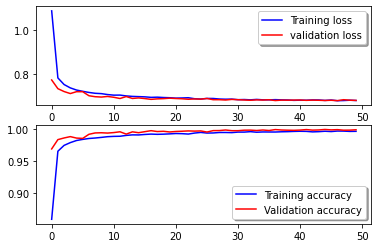

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.7107694149017334
Test accuracy: 0.9926999807357788


In [17]:
test_size = y_test.size/10
test_size

10000.0

In [18]:
predictions = model.predict(x_test)

In [19]:
correct_numbers = np.empty(int(test_size))
for i in range(int(test_size - 1)):
    correct_numbers[i] = y_test[i].argmax()

In [20]:
prediction_numbers = np.empty(int(test_size))
for i in range(int(test_size - 1)):
    prediction_numbers[i] = predictions[i].argmax()

In [21]:
distance = prediction_numbers - correct_numbers
distance = abs(distance)
print("数値の差 : {}".format(abs(distance.sum())))
print("1枚の画像あたり : {}　の差".format(abs(distance.sum()) / test_size))

数値の差 : 265.0
1枚の画像あたり : 0.0265　の差


In [22]:
count_distance = np.zeros(10)
for i in range(10):
  for j in range(int(test_size)):
    if(distance[j] == i):
      count_distance[i] = count_distance[i] + 1

In [23]:
count_distance

array([9.926e+03, 1.200e+01, 1.900e+01, 2.000e+00, 7.000e+00, 2.100e+01,
       9.000e+00, 2.000e+00, 1.000e+00, 0.000e+00])

In [24]:
kenzan = 0
for i in range(10):
  kenzan += i*count_distance[i]
kenzan

265.0

In [25]:
test_maisu = 0
for i in range(10):
  test_maisu += count_distance[i]
test_maisu

9999.0

### 間違えたときの数値誤差

In [26]:
print("間違えたときの数値の差 : {}".format(kenzan /(test_size - count_distance[0])))

間違えたときの数値の差 : 3.581081081081081


### 混同行列(testデータ)

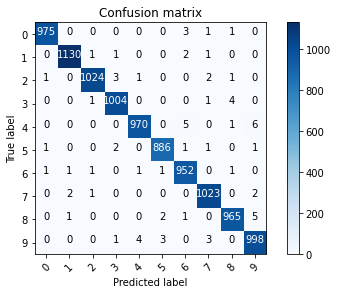

In [27]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

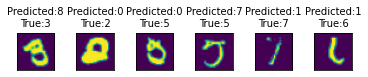

In [28]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

###
number_of_error = 0
for i in errors:
  if i :
    number_of_error += 1
minas_number_of_error = -1 * number_of_error
###

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    # nrows = 1#int(number_of_error / 4) + 1   ####
    ncols = 6

    fig, ax = plt.subplots(1, ncols,sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0.6, hspace=0.5) ##図同士の間隔を調整

    for col in range(ncols):
        error = errors_index[n]
        ax[col].imshow((img_errors[error]).reshape((32,32)))
        ax[col].set_title("Predicted:{}\nTrue:{}".format(pred_errors[error],obs_errors[error]), fontsize = 10)
        ax[col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax[col].tick_params(bottom=False, left=False, right=False, top=False)
        n += 1
    # for row in range(nrows):
    #     for col in range(ncols):
    #         error = errors_index[n]
    #         ax[row,col].imshow((img_errors[error]).reshape((28,28)))
    #         ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]), fontsize = 5)
    #         ax[row,col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #         ax[row,col].tick_params(bottom=False, left=False, right=False, top=False)
    #         n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:] #minas_number_of_error 

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### 混同行列(valデータ)

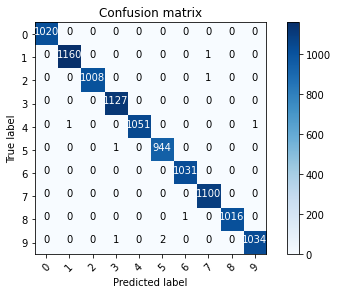

In [29]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

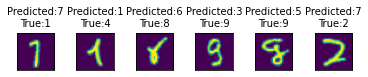

In [30]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

###
number_of_error = 0
for i in errors:
  if i :
    number_of_error += 1
minas_number_of_error = -1 * number_of_error
###

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    # nrows = 1#int(number_of_error / 4) + 1   ####
    ncols = 6

    fig, ax = plt.subplots(1, ncols,sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0.6, hspace=0.5) ##図同士の間隔を調整

    for col in range(ncols):
        error = errors_index[n]
        ax[col].imshow((img_errors[error]).reshape((32,32)))
        ax[col].set_title("Predicted:{}\nTrue:{}".format(pred_errors[error],obs_errors[error]), fontsize = 10)
        ax[col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax[col].tick_params(bottom=False, left=False, right=False, top=False)
        n += 1
    # for row in range(nrows):
    #     for col in range(ncols):
    #         error = errors_index[n]
    #         ax[row,col].imshow((img_errors[error]).reshape((28,28)))
    #         ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]), fontsize = 5)
    #         ax[row,col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #         ax[row,col].tick_params(bottom=False, left=False, right=False, top=False)
    #         n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:] #minas_number_of_error 

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [31]:
number_of_error = 0
for i in errors:
  if i :
    number_of_error += 1
number_of_error

9